In [ ]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from json import load
import joblib


# read kmean inputs 
## file path is written in local, not availiable on drive

In [ ]:
# read kmean files
X_train = np.load("kmeans=4_train.npy").reshape((720, -1))
y_train = np.load("y_train.npy")
X_test = np.load("kmeans=4_test.npy").reshape((240, -1))
y_test = np.load("y_test.npy")
X_validation = np.load("kmeans=4_val.npy").reshape((240,-1))
y_validation = np.load("y_val.npy")

X_train = np.concatenate((X_train, X_validation), 0)    # axis = 0 => concatenate row axis
y_train = np.concatenate((y_train, y_validation), 0)

# define parameter grid 

In [ ]:
n_estimator = [50, 100, 200]                # number of trees in random forest, mostly correlated to the size of data
max_features = ['sqrt', 'log2']             # number of features in consideration at every split
max_depth = [20,50,60]                      # max levels allowed in each decision tree
min_samples_split = [2,4,6]                 # min samples to split a node
min_samples_leaf = [5,8,10]                 # min samples that can be stored in a leaf node
bootstrap = [True, False]                   # method used to sample data points (decide to use whole data for every decision tree or not))
criterion = ['gini', 'entropy']             # The criteria with which to split on each node
parameter_grid = {
    'n_estimators': n_estimator,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion' : criterion,
    'bootstrap': bootstrap
}


# Using gridsearchCV to find best parameters

In [ ]:
# find Best Hyperparameter using GridSearchCV
rnd_clf = RandomForestClassifier()
CV_rnd_clf = GridSearchCV(estimator=rnd_clf, param_grid=parameter_grid, cv=4, n_jobs=-1)

CV_rnd_clf.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 50, 60],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 8, 10],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]})

In [ ]:
y_pred = CV_rnd_clf.predict(X_test)
print(CV_rnd_clf.best_score_)
print(accuracy_score(y_test, y_pred))

0.44687499999999997
0.425


# save gridsearchCV model 

In [ ]:

#save model or results
joblib.dump(CV_rnd_clf, 'RF_CV.pkl')



GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 50, 60],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 8, 10],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]})

In [ ]:
#load model for further usage
CV_rnd_clf=joblib.load("RF_CV.pkl")
# print out best parameters
print(CV_rnd_clf.best_params_)

y_pred = CV_rnd_clf.predict(X_test)
print(CV_rnd_clf.best_score_)
print(accuracy_score(y_test, y_pred))

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}
0.44687499999999997
0.425


# plot micro-average and macro-average of best parameters

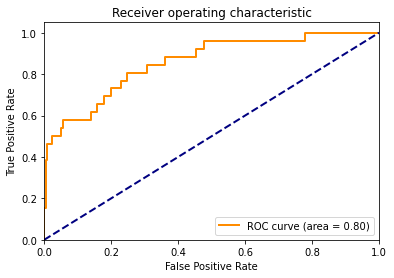

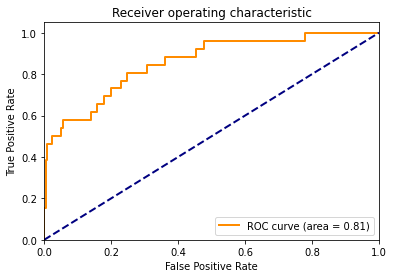

In [ ]:
from sklearn_evaluation import plot
from sklearn.metrics import roc_curve, auc
# using best parameters from GridSearch and evaluate the model 

y_train1 = label_binarize(y_train, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_test1 = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])
classifier = OneVsRestClassifier(
    RandomForestClassifier(
        random_state= 42,
        n_estimators= 200,
        max_features= 'sqrt',
        max_depth= 20,
        min_samples_split= 4,
        min_samples_leaf= 5,
        criterion= 'gini',
        bootstrap= True
    )
)
y_score = classifier.fit(X_train, y_train1).predict_proba(X_test)

y_pred1 = classifier.predict(X_test)
n_classes = 10
# # Learn to predict each class against the other
# classifier = OneVsRestClassifier(
#     svm.SVC(kernel="linear", probability=True, random_state=random_state)
# )
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc['micro'],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc['macro'],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()




In [ ]:
print(roc_auc.keys())
print(roc_auc[2])
print(roc_auc)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'micro', 'macro'])
0.8572969086987778
{0: 0.6127232142857143, 1: 0.6502325581395348, 2: 0.8572969086987778, 3: 0.7860717264386989, 4: 0.7978334065290587, 5: 0.8775820830615352, 6: 0.8153293021735578, 7: 0.9352033050663187, 8: 0.8791291291291291, 9: 0.8199052132701421, 'micro': 0.8027334104938271, 'macro': 0.8056471683517314}


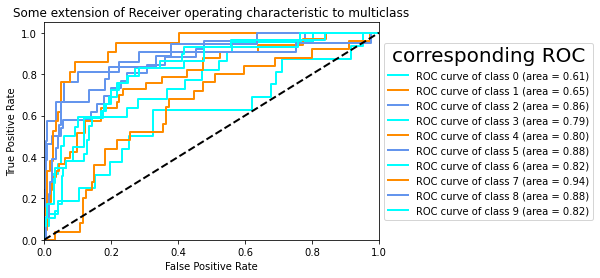

In [ ]:
from itertools import cycle
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(title='corresponding ROC',title_fontsize=20,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# plot confusion matrix of best parameters

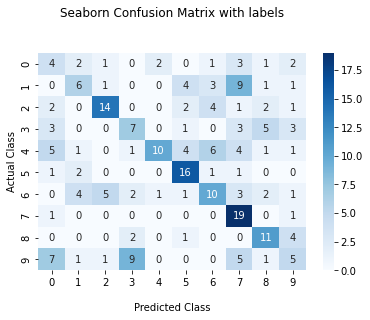

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn_evaluation import plot
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('Actual Class');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])

## Display the visualization of the Confusion Matrix.
plt.show()


# run Classification report

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))

# accuracy score represents the ratio of the sum of true positive and true negatives out of all the predictions.
# print("Accuracy for Random Forest on CV data: ", accuracy_score(y_test, y_pred))

# precision score measures the proportion of positively predicted labels that are actually correct
# print("precision score ",precision_score(y_test, y_pred, average="macro"))

# recall score represents the model’s ability to correctly predict the positives out of actual positives
# print("recall_score ", recall_score(y_test, y_pred, average="macro"))  

# f1 score represents the model score as a function of precision and recall score
# print("f1_score ",f1_score(y_test, y_pred, average="macro"))

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

[[ 4  2  1  0  2  0  1  3  1  2]
 [ 0  6  1  0  0  4  3  9  1  1]
 [ 2  0 14  0  0  2  4  1  2  1]
 [ 3  0  0  7  0  1  0  3  5  3]
 [ 5  1  0  1 10  4  6  4  1  1]
 [ 1  2  0  0  0 16  1  1  0  0]
 [ 0  4  5  2  1  1 10  3  2  1]
 [ 1  0  0  0  0  0  0 19  0  1]
 [ 0  0  0  2  0  1  0  0 11  4]
 [ 7  1  1  9  0  0  0  5  1  5]]
              precision    recall  f1-score   support

           0       0.17      0.25      0.21        16
           1       0.38      0.24      0.29        25
           2       0.64      0.54      0.58        26
           3       0.33      0.32      0.33        22
           4       0.77      0.30      0.43        33
           5       0.55      0.76      0.64        21
           6       0.40      0.34      0.37        29
           7       0.40      0.90      0.55        21
           8       0.46      0.61      0.52        18
           9       0.26      0.17      0.21        29

    accuracy                           0.42       240
   macro avg       

In [ ]:
c = confusion_matrix(y_test, y_pred)
sum1 = {}
for i in range(0, len(c)):
    sum1[i] = 0
    for j in range(0, len(c[i])):
        sum1[i] += c[i][j]
print(sum1)
s = 0
for val in sum1.values():
    s += val
print(s)

{0: 16, 1: 25, 2: 26, 3: 22, 4: 33, 5: 21, 6: 29, 7: 21, 8: 18, 9: 29}
240


# Save CV results of all parameter combo into csv file

In [ ]:
cv_results = CV_rnd_clf.cv_results_
print(cv_results.keys())
print(len(cv_results))
cv_re = []

for i in range(0, len(cv_results['params'])):
    cv_re.append(
        {
        'param_bootstrap': cv_results['param_bootstrap'][i],
        'param_criterion': cv_results['param_criterion'][i],
        'param_max_depth':cv_results['param_max_depth'][i],
        'param_max_features':cv_results['param_max_features'][i],
        'param_min_samples_leaf':cv_results['param_min_samples_leaf'][i],
        'param_min_samples_split':cv_results['param_min_samples_split'][i],
        'param_n_estimators':cv_results['param_n_estimators'][i],
        'params':cv_results['params'][i],
        'split0_test_score':cv_results['split0_test_score'][i],
        'split1_test_score':cv_results['split1_test_score'][i],
        'split2_test_score':cv_results['split2_test_score'][i],
        'split3_test_score':cv_results['split3_test_score'][i],
        'mean_test_score':cv_results['mean_test_score'][i],
        'std_test_score':cv_results['std_test_score'][i],
        'rank_test_score':cv_results['rank_test_score'][i],
        }
    )

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
19


In [ ]:
import csv 
field_names = ['param_bootstrap', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']
with open('RF_CVresults_final.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = field_names)
    writer.writeheader()
    writer.writerows(cv_re)

In [ ]:
results_df = pd.DataFrame(CV_rnd_clf.cv_results_)
print(len(results_df))

648


In [ ]:
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]


,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
True_gini_20_sqrt_5_4_200,"{'bootstrap': True, 'criterion': 'gini', 'max_...",1,0.446875,0.041182
False_gini_20_sqrt_5_6_200,"{'bootstrap': False, 'criterion': 'gini', 'max...",2,0.441667,0.025685
False_gini_20_log2_5_6_200,"{'bootstrap': False, 'criterion': 'gini', 'max...",3,0.440625,0.034280
False_gini_20_log2_5_4_200,"{'bootstrap': False, 'criterion': 'gini', 'max...",4,0.439583,0.019654
False_gini_50_log2_5_2_100,"{'bootstrap': False, 'criterion': 'gini', 'max...",5,0.437500,0.017922
...,...,...,...,...
True_entropy_50_log2_8_6_50,"{'bootstrap': True, 'criterion': 'entropy', 'm...",644,0.336458,0.026249
True_entropy_20_sqrt_10_2_50,"{'bootstrap': True, 'criterion': 'entropy', 'm...",645,0.334375,0.016238
True_entropy_60_log2_10_6_50,"{'bootstrap': True, 'criterion': 'entropy', 'm...",645,0.334375,0.030813


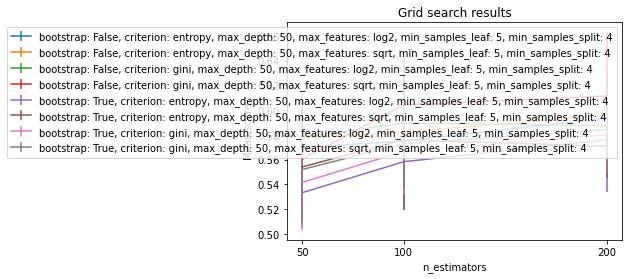

In [ ]:
from sklearn_evaluation.plot import grid_search
grid_search(CV_rnd_clf.cv_results_, change='n_estimators')
plt.show()

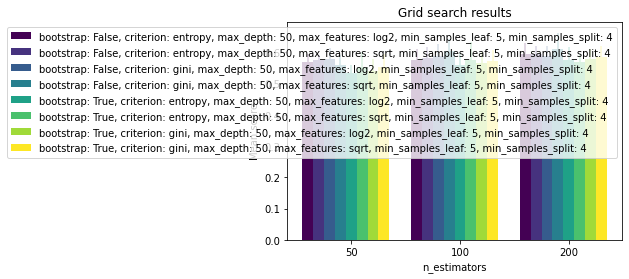

In [ ]:
grid_search(CV_rnd_clf.cv_results_, change='n_estimators', kind='bar')
plt.show()

<AxesSubplot:title={'center':'Grid search results'}, xlabel='n_estimators', ylabel='Mean score'>

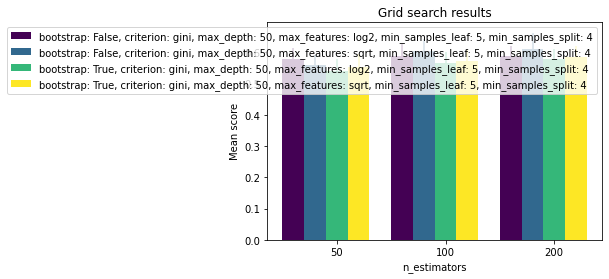

In [ ]:
grid_search(CV_rnd_clf.cv_results_, change='n_estimators',
                 subset={'n_estimators': [50, 100, 200],
                         'criterion': 'gini'},
                 kind='bar')